*Might be interesting:* Short [article](http://scienceblogs.com/cognitivedaily/2007/03/29/most-researchers-dont-understa/) on error bars and significance

# Instructions
1. To run notebook, go to the `Cell` menu above and click `Run All`. 
2. To hide all the code, just click the `Results Only` button above.
3. If something goes really wrong, then go to the `Kernel` menu above and click `Restart` and repeat Step 1.

You can interact with the plot below to select which combination of groups and dates you want to show.
You can CTRL+Click to select multiple items in the menus below.  

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import IPython.html.widgets as widgets
import os

from ggplot import *

from IPython.html.widgets import \
    interact,\
    interactive,\
    fixed

from IPython.display import \
    display,\
    clear_output

from pandas.tools.plotting import \
    scatter_matrix

from pandas import \
    DataFrame as df

from view import \
    plot_plates,\
    matrix_tree
    
from toolz import \
    pipe,\
    thread_first
    
from utils import \
    normalize_columns,\
    filter_and_drop,\
    filter_rows,\
    snd,\
    add_col,\
    get_files,\
    gen_filenames,\
    maybe_get_model,\
    persist_widget_value,\
    concatenate,\
    are_all_in

In [26]:
matplotlib.style.use('ggplot')

In [27]:
path = '/notebooks/Seahorse/'
files = filter(lambda x: not x.startswith('.'), os.listdir(path))

In [28]:
data_files = filter(lambda f: 'data' in f,files)
norm_files = filter(lambda f: 'Norm' in f,files)

In [29]:
def rename_measurement_col(name):
    if 'Measure' in name:
        return name.split()[0]
    else: 
        return name
    
# String -> DataFrame
def get_data(filename,date):
    return thread_first(
        filename,
        pd.read_csv,
        lambda d: d.rename(columns=rename_measurement_col),
        lambda d: add_col(d,'Date',date))

# String -> DataFrame
def get_norm(filename,date):
    return thread_first(
        filename,
        lambda x: pd.read_csv(x,header=-1,names=['Group','Factor']),
        lambda d: d.rename(columns=rename_measurement_col),
        lambda d: add_col(d,'Date',date))
    

In [30]:
raw_data = pd.concat(
    [get_data(os.path.join(path,filename),filename.split()[0])
        for filename in data_files]).dropna(how='all',axis=1)

In [31]:
norm_data = pd.concat(
    [get_norm(os.path.join(path,filename),filename.split()[0])
        for filename in norm_files]).rename(columns = {'Back. Corr.': "Group"})
norm_data['Group'] = norm_data['Group'].map(lambda x: x.lstrip(' ').rstrip(' '))

In [32]:
raw_and_norm_data = pd.merge(raw_data,norm_data, on = ['Date','Group'],how='left')

In [33]:
background_data = raw_and_norm_data[raw_and_norm_data['Group'] == 'Back. Corr.']

In [34]:
background_means = \
    background_data\
    .groupby(['Date','Measurement'])\
    .mean()\
    .reset_index()\
    .rename(
        columns={"OCR":"Background OCR",
                 "ECAR": "Background ECAR"})\
    .drop('Factor',axis=1)

In [35]:
background_means.dropna(how = 'all',axis=1)

,Date,Measurement,Background ECAR,Background OCR
0,7-17,1,-8.8700,-37.8850
1,7-17,2,-1.3475,-15.9525
2,7-17,3,1.1450,-16.1975
3,7-17,4,1.5250,-9.7475
4,7-17,5,1.7975,-4.9900
5,7-17,6,2.6125,-10.5300
6,7-17,7,2.3875,-10.2650
7,7-17,8,2.6500,-10.9000
8,7-17,9,2.3375,-1.9450
9,7-17,10,2.4875,2.2375


In [36]:
data = pd.merge(raw_and_norm_data,
                background_means,
                on=['Date','Measurement'])

In [37]:
# DataFrame -> Boolean -> Boolean -> DataFrame
def subtract_background_and_normalize(data,subtract_background = True, normalize = True):
    """ Given a dataframe, return a copy with the background subtracted 
        and data rescaled by the given factor. """
    new_data = data.copy()
    if subtract_background:
        new_data['OCR'] = new_data['OCR'] - new_data['Background OCR']
        new_data['ECAR'] = new_data['ECAR'] - new_data['Background ECAR']
    if normalize:
        new_data['OCR'] = new_data['OCR'] * new_data['Factor']
        new_data['ECAR'] = new_data['ECAR'] * new_data['Factor']
    return new_data

In [38]:
def plot_results(data, groups, dates,subtract_background, normalize, show_errorbars, show_error_fill, show_median, error_measure, parameter):
    
    groups = list(groups)
    dates = list(dates)
    
    new_data = subtract_background_and_normalize(data,subtract_background, normalize)
    filtered_groups = new_data[new_data['Group'].isin(groups)]
    filtered_dates = filtered_groups[filtered_groups['Date'].isin(dates)]
    
    groupbys = filtered_dates.groupby(['Measurement','Group'])
    means = groupbys.mean()[[parameter]].unstack()[parameter]
    medians = groupbys.median()[[parameter]].unstack()[parameter]
    stds =  groupbys.std()[[parameter]].unstack()[parameter]
    sems =  groupbys.sem()[[parameter]].unstack()[parameter]
    
    # fill, errorbars, error measure
    
    if error_measure == 'SEM':
        errs = sems
    else: 
        errs = stds
    
    if show_median:
        medians.plot(kind='line', linewidth = 2)
#         for group in filtered_dates['Group'].unique().tolist():
#             plt.plot(medians.index, medians[group],'--')
    
    else:
        if show_errorbars:
            means.plot(kind='line', yerr = errs, linewidth = 2, capsize=3, capthick = 4, fmt = '-o')
        else:
            means.plot(kind='line', linewidth = 2)
    
    if show_error_fill:
        for group in filtered_dates['Group'].unique().tolist():
            plt.fill_between(means.index, means[group] - errs[group], means[group] + errs[group], alpha=0.3)
     
    fig = plt.gcf()
    fig.set_size_inches(17,8)
    plt.ylabel(parameter)
    plt.title("{}{}{}{}".format(
        parameter,
        ', normalized' if normalize else '',
        ', minus background' if subtract_background else '',
        ' (errorbars = {})'.format(error_measure) if show_errorbars or show_error_fill else ''))

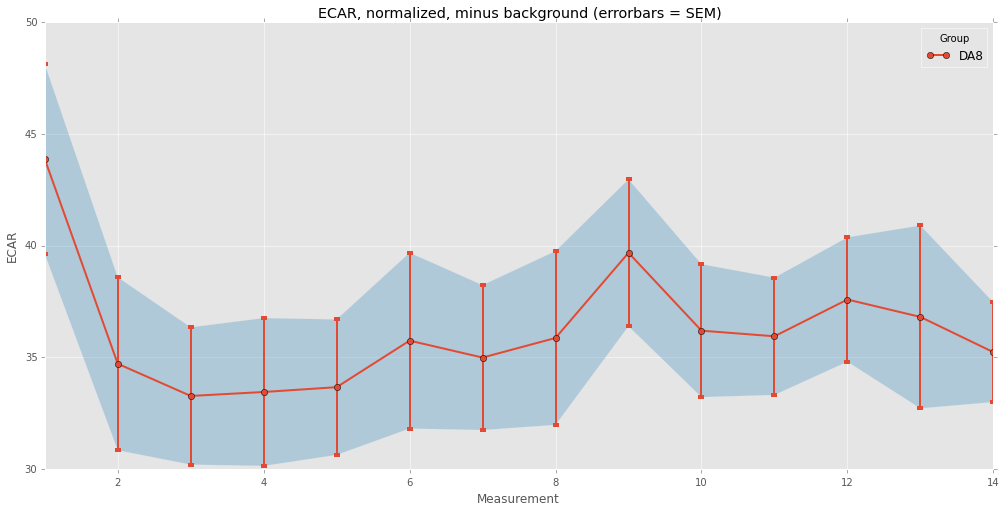

In [39]:
group_options = data['Group'].unique().tolist()
date_options = sorted(data['Date'].unique().tolist())

interact(
    plot_results,
    data = fixed(data),
    groups = widgets.SelectMultiple(
        options = group_options,
        value = group_options),
    dates = widgets.SelectMultiple(
        options = date_options,
        value = date_options),
    subtract_background = True, 
    normalize = True, 
    show_errorbars = True, 
    show_error_fill = True,
    show_median = False,
    error_measure = widgets.ToggleButtons(
        options = ['SEM','STD'],
        value = 'SEM'),
    parameter = widgets.ToggleButtons(
        options = ['OCR','ECAR'],
        value = 'OCR'));

# Show individual points

In [40]:
def plot_points(data, groups, dates,subtract_background, normalize, parameter):
    np.random.seed(10030423)
    groups = list(groups)
    dates = list(dates)
    
    new_data = subtract_background_and_normalize(data,subtract_background, normalize)
    filtered_groups = new_data[new_data['Group'].isin(groups)]
    filtered_dates = filtered_groups[filtered_groups['Date'].isin(dates)]
    
    if not groups |are_all_in| filtered_dates['Group'].unique().tolist():
        missing_groups = list(set(groups).difference(set(filtered_dates['Group'].unique().tolist())))
        print "It looks like there might not be data for these groups for the day(s) you've chosen: {} .".format(' '.join(missing_groups))
        return
    jittered_data = filtered_dates[filtered_dates['Group'].isin(groups)].copy()
    jitter_strength = 0.4
    jittered_data['Measurement'] = jittered_data['Measurement'].map(lambda x: x + np.random.random() * jitter_strength)
    
    display(ggplot(aes(x = 'Measurement',y = parameter, color = 'Group'), data = jittered_data.reset_index(drop=True)) + geom_point());

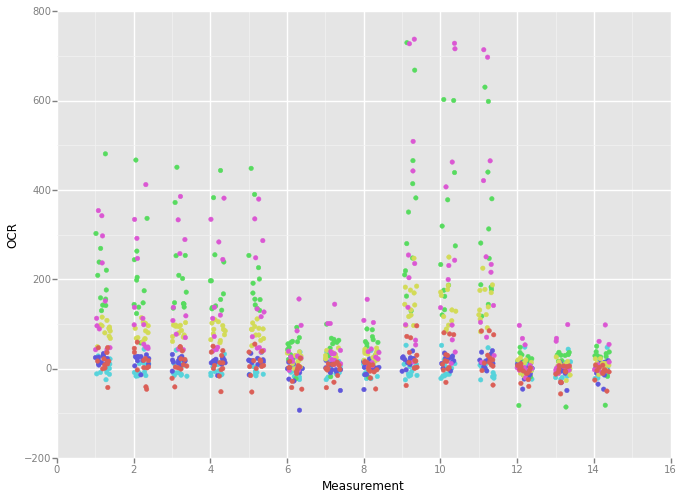

<ggplot: (8775483367109)>

In [41]:
interact(
    plot_points,
    data = fixed(data),
    groups = widgets.SelectMultiple(
        options = group_options,
        value = group_options),
    dates = widgets.SelectMultiple(
        options = date_options,
        value = date_options),
    subtract_background = True, 
    normalize = True, 
    parameter = widgets.ToggleButtons(
        options = ['OCR','ECAR'],
        value = 'OCR'));

In [42]:
# pip uninstall ggplot
# pip install git+git://github.com/yhat/ggplot.git

In [43]:
data.to_csv('/notebooks/seahorse-data.csv',index=False)

In [44]:
# d[d['Date'] == '7-17'].groupby(['Measurement','Group']).mean()


In [45]:
data['Date'].unique()

array(['7-19', '7-17', '7-20'], dtype=object)

In [46]:
mysems = data.groupby(['Date','Measurement','Group']).sem().reset_index()
mymeans = data.groupby(['Date','Measurement','Group']).mean().reset_index()

In [47]:
mymeans.to_csv('/notebooks/seahorse-means.csv',index=False)
mysems.to_csv('/notebooks/seahorse-sems.csv',index=False)

In [48]:
from IPython.display import FileLink, FileLinks
FileLinks('/notebooks/')

/notebooks/
  random number generation.ipynb
  07-16-15.tar
  seahorse-sems.csv
  seahorse-means.csv
  EconDataFromDee.csv
  seahorse-data.csv
/notebooks/.ipynb_checkpoints/
  draft-parsing multiplate datasets-checkpoint.ipynb
  random number generation-checkpoint.ipynb
  06-19-2015-checkpoint.ipynb
/notebooks/Seahorse/
  7-19 OCAR-ECAR data.csv
  7-19 Normalization.csv
  7-17 OCAR-ECAR data.csv
  7-20 OCAR-ECAR data.csv
  7-20 Normalization.csv
  7-17 Normalization.csv
/notebooks/assay-explorer/
  Economics.ipynb
  DATAVIS - 6.19.2015 - ssC.ipynb
  DATAVIS - 7.15.2015 - ssC-PNA-Refactor.ipynb
  Seahorse.ipynb
  DATAVIS - 7.15.2015 - APB-PNA.ipynb
  DATAVIS - 6.24.2015 - ssC-PNA-Copy1.ipynb
  DATAVIS - 6.19.2015 - APB.ipynb
  Untitled.ipynb
  DATAVIS - 7.15.2015 - ssC-PNA.ipynb
  DATAVIS - 6.24.2015 - ssC-PNA.ipynb
  .gitignore
  Economics-Copy1.ipynb
  DATAVIS - 7.15.2015 - ssC-PNA-CellPhase.ipynb
  DATAVIS - 7.15.2015 - APB-PNA-CellPhase.ipynb
  DATAVIS - 6.24.2015 - ssC-LNA.ipynb
/notebooks/assay-explorer/.git/
  ORIG_HEAD
  HEAD
  index
  COMMIT_EDITMSG
  config
  description
  packed-refs
/notebooks/assay-explorer/.git/hooks/
  pre-rebase.sample
  applypatch-msg.sample
  commit-msg.sample
  pre-push.sample
  pre-applypatch.sample
  update.sample
  prepare-commit-msg.sample
  pre-commit.sample
  post-update.sample
/notebooks/assay-explorer/.git/info/
  exclude
/notebooks/assay-explorer/.git/logs/
  HEAD
/notebooks/assay-explorer/.git/logs/refs/heads/
  master
/notebooks/assay-explorer/.git/logs/refs/remotes/origin/
  HEAD
  master
/notebooks/assay-explorer/.git/objects/00/
  1fa0ecf9cf365b249643bc63712c0e398df3f4
/notebooks/assay-explorer/.git/objects/01/
  da3b8401cc5e7b4047d551e25e1d28e490d946
  1f018a1086d72e2af9e424da14538d8d5b98dd
/notebooks/assay-explorer/.git/objects/04/
  b8ddd8c3222dfb646d66b104d2ae00a98ce592
  413f67f27b0bfc8c9b2918834ea46adc487a66
  ab2494918d939f42f65fe270b741b5c7a1fff7
  4d7f392680c6a7a328841d6d4681af6f1772e0
  bc845fe4e18594721fa7bb98c40f58914536c7
  78a0c4a298f68f63bf63dcd678f4d8f7eabb2f
/notebooks/assay-explorer/.git/objects/05/
  306baf8335efa07ede5178363bb711678d7721
  c39c5fe1b744d823194c87560264808b9241f3
/notebooks/assay-explorer/.git/objects/06/
  d966653a142f85ac3762789e299b77e95e3a11
  ae732ef870b011a8264625f9f96b0a114366f6
/notebooks/assay-explorer/.git/objects/07/
  86a6dbf546cd4a86c2dd27ca14c7fd55843e72
  0070787a939157fb86c833fe75f6ba040cfe6b
/notebooks/assay-explorer/.git/objects/08/
  5fac91ac5801593d0f04bccc2afae90e4a061f
  0b17af077dff9134f9057202a8e86fc8870e3e
/notebooks/assay-explorer/.git/objects/09/
  c4480c88a9ca16be43eaae9750d3456ae0fd3d
  97c5527cb5c4888fe525a7b9b2518e55823b80
  3eed589c0f53bd68d9f57394adf73e9d2b2cd2
  5122b1084b51d1fc76b7373311e46f29e0ea40
  a5aad51df120de765a06cc1b353b33ab1381c9
  40b71de3ae293edbd65774b6efa6551f0f0287
  4a80641cadbb0339de8b47bfb8a0ad94a4216b
/notebooks/assay-explorer/.git/objects/0a/
  593e8a0ecd6839e9fd65b04f383fbf1f7fca70
  5166ec9e7c53e509904ca59ef8ccd960655341
  303f832f2bd85704d96354924e490b983752f1
  de5d55d9f0771ba88483df167c722ab4d9d610
/notebooks/assay-explorer/.git/objects/0b/
  a613e92881f37357551de0d3e212996dd0cb5c
/notebooks/assay-explorer/.git/objects/0d/
  d7aef836772796464d2c56f41effbcbcf7d1d5
/notebooks/assay-explorer/.git/objects/0e/
  4433b8657309aa0051b5b359da351cb5eb1a49
  290213bf96c325c07d54c3f36a12f2b8946951
  eff3ee0f1ae64441d7c1389ecd6ab768cf2e62
/notebooks/assay-explorer/.git/objects/0f/
  1802332eddbb3ebe4e76d0865d301f0c59e0c9
  0e87cacc48855a142f602de2d0a74d1216d548
  02671665b44b45ed5f1899c235cbd922ed8d5e
/notebooks/assay-explorer/.git/objects/11/
  d4a28ff2f8afc65d3c9da2166f9932ff1667e7
  680ac8db94b14a174aaa6fbf2c9a282c87bfcc
/notebooks/assay-explorer/.git/objects/12/
  6d3a5f2df84a9558efc8ae6fc2f11ab694fb87
/notebooks/assay-explorer/.git/objects/15/
  61d842588318f5443232b37c252155990c7911
  b1111dae6a7c19c35b73ab0d134be6fbc907d8
/notebooks/assay-explorer/.git/objects/16/
  4467e07c4fca7ef2395a4371a